In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
from PIL import Image

import tensorflow as tf
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Lambda, Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, SpatialDropout2D, GlobalAveragePooling2D

from keras.callbacks import EarlyStopping


from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocessor
from keras.applications.xception import Xception, preprocess_input as xception_preprocessor
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inc_resnet_preprocessor
from keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_preprocessor
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_files
from io import BytesIO
import seaborn as sns
import xml.etree.ElementTree as ET
from pathlib import Path
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [47]:
# def get_image(annot):
#     img_path = annot
#     file = annot.split('.')
#     img_filename = file[0]+'.jpg'
#     return img_filename
def get_image(annot):
    img_path = '../input/stanford-dogs-dataset/images/Images/'
    file = annot.split('/')
    img_filename = img_path + file[-2]+'/'+file[-1]+'.jpg'
    return img_filename


In [48]:
%matplotlib inline
import glob
%config InlineBackend.figure_format = 'svg'
dog_images = glob.glob('../input/stanford-dogs-dataset/images/Images/*/*')
breeds = glob.glob('../input/stanford-dogs-dataset/annotations/Annotation/*')
annotations = glob.glob('../input/stanford-dogs-dataset/annotations/Annotation/*/*')
cropped = "./Cropped/"
img_size = 299 # For Xception input
train_dir = './Cropped' # './Images'
batch_size_training = 256
batch_size_validation = 256
input_shape = (img_size,img_size,3)

In [49]:
import xml.etree.ElementTree as ET
from PIL import Image
import os

annotations=[]
folder_path = '/content/drive/MyDrive/Dog_Images'
if os.path.exists(folder_path) and os.path.isdir(folder_path):
  for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        annotations.append(file_path)
print(annotations)
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox

import os
from PIL import Image

for i in range(len(dog_images)):
    bbox = get_bounding_boxes(annotations[i])
    dog = get_image(annotations[i])  # You need to define this function to get the image path
    im = Image.open(dog)
    for j in range(len(bbox)):
        im2 = im.crop(bbox[j])
        im2 = im2.resize((128, 128), Image.ANTIALIAS)
        new_path = dog.replace('/content/drive/MyDrive/Dog_Images', './Cropped/')
        new_path = new_path.replace('.jpg', '-' + str(j) + '.jpg')
        im2 = im2.convert('RGB')
        head, tail = os.path.split(new_path)
        os.makedirs(head, exist_ok=True)
        im2.save(new_path)


['/content/drive/MyDrive/Dog_Images/Newfoundland.jpeg', '/content/drive/MyDrive/Dog_Images/Tibetan_mastiff.jpeg', '/content/drive/MyDrive/Dog_Images/Kerry_blue_terrier.jpeg', '/content/drive/MyDrive/Dog_Images/Saluki.jpeg']


Edge histogram

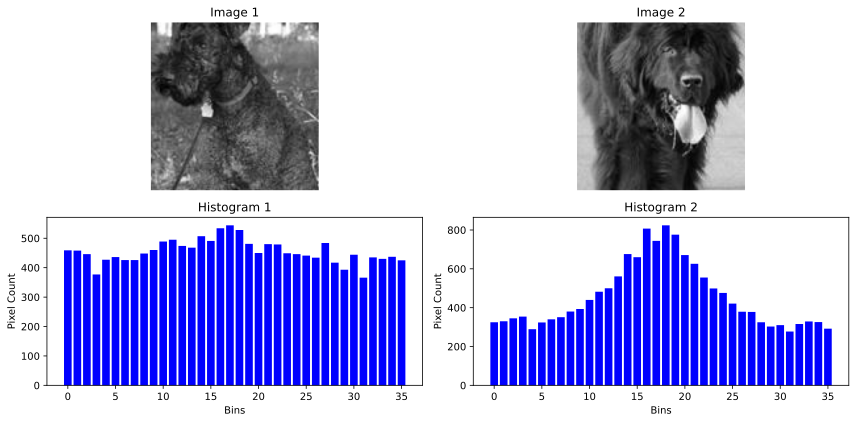

In [50]:

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure

# i. Choose 1 image from each class
image_paths = ['/content/drive/MyDrive/Dog_Images/Kerry_blue_terrier.jpeg', '/content/drive/MyDrive/Dog_Images/Newfoundland.jpeg']

# ii. Convert the color images to grayscale images
gray_images = []
for path in image_paths:
    image = io.imread(path)
    gray_image = color.rgb2gray(image)
    gray_images.append(gray_image)

# iii. Calculate the angle for each pixel in the grayscale images
def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

angle_images = []
for image in gray_images:
    sobel_h = filters.sobel_h(image)
    sobel_v = filters.sobel_v(image)
    angle_image = angle(sobel_h, sobel_v)
    angle_images.append(angle_image)

# iv. Use skimage.exposure.histogram to obtain a histogram with 36 bins
histograms = []
for angle_image in angle_images:
    hist, _ = exposure.histogram(angle_image, nbins=36)
    histograms.append(hist)

# v. Plot the images with their corresponding edge histogram values
plt.figure(figsize=(12, 6))
for i in range(len(image_paths)):
    plt.subplot(2, 2, i+1)
    plt.imshow(gray_images[i], cmap='gray')
    plt.title('Image {}'.format(i+1))
    plt.axis('off')

    plt.subplot(2, 2, i+3)
    plt.bar(range(36), histograms[i], width=0.8, color='blue')
    plt.xlabel('Bins')
    plt.ylabel('Pixel Count')
    plt.title('Histogram {}'.format(i+1))

plt.tight_layout()
plt.show()

Histogram Comparison (Measures of Similarity and Dissimilarity)

In [51]:
from skimage import io, color, filters
import numpy as np
from scipy.spatial import distance

# Load images (replace with your image paths)
image1 = io.imread('/content/drive/MyDrive/Dog_Images/Tibetan_mastiff.jpeg')  # Image from class A
image2 = io.imread('/content/drive/MyDrive/Images/n02108551-Tibetan_mastiff/n02108551_10182.jpg')  # Another image from class A
image3 = io.imread('/content/drive/MyDrive/Dog_Images/Kerry_blue_terrier.jpeg')  # Image from class B

def edge_histogram(image):
    image_gray = color.rgb2gray(image)
    edges = filters.sobel(image_gray)
    hist, _ = np.histogram(edges, bins=36, range=(0, 1))
    return hist / np.sum(hist)  # Normalize the histogram

# Compute edge histograms
hist1 = edge_histogram(image1)
hist2 = edge_histogram(image2)
hist3 = edge_histogram(image3)
histogram = []
histogram.append(hist1)
histogram.append(hist2)
histogram.append(hist3)

# Compare histograms
euclidean_dist = distance.euclidean(hist1, hist2)
manhattan_dist = distance.cityblock(hist1, hist2)
cosine_dist = distance.cosine(hist1, hist2)

# Compare histograms
euclidean_dist_2_and_3 = distance.euclidean(hist2, hist3)
manhattan_dist_2_and_3 = distance.cityblock(hist2, hist3)
cosine_dist_2_and_3 = distance.cosine(hist2, hist3)

print("Euclidean Distance 1 and 2:", euclidean_dist)
print("Manhattan Distance 1 and 2:", manhattan_dist)
print("Cosine Distance 1 and 2:", cosine_dist)


print("Euclidean Distance 2 and 3:", euclidean_dist_2_and_3)
print("Manhattan Distance 2 and 3:", manhattan_dist_2_and_3)
print("Cosine Distance 2 and 3:", cosine_dist_2_and_3)

Euclidean Distance 1 and 2: 0.0876421814420395
Manhattan Distance 1 and 2: 0.2032758131377551
Cosine Distance 1 and 2: 0.00953938733110149
Euclidean Distance 2 and 3: 0.2352322080200174
Manhattan Distance 2 and 3: 0.47623010602678567
Cosine Distance 2 and 3: 0.08215085971145653


Image Processing

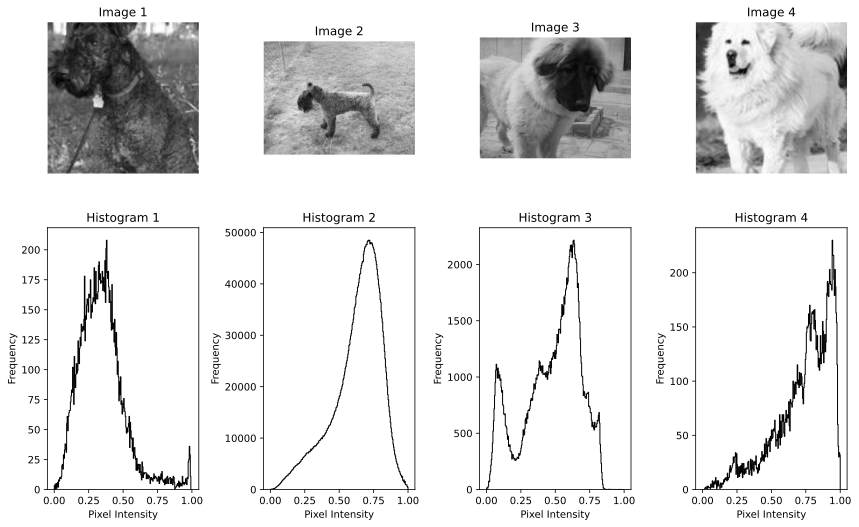

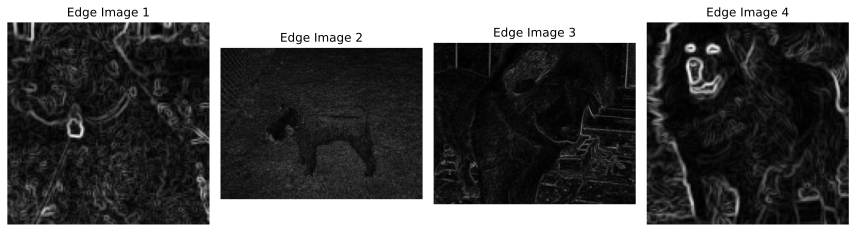

In [52]:
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure
import numpy as np

# i. Choose 2 images from each class
image_paths = ['/content/drive/MyDrive/Dog_Images/Kerry_blue_terrier.jpeg', '/content/drive/MyDrive/Images/n02093859-Kerry_blue_terrier/n02093859_1003.jpg', '/content/drive/MyDrive/Images/n02108551-Tibetan_mastiff/n02108551_103.jpg', '/content/drive/MyDrive/Dog_Images/Tibetan_mastiff.jpeg']

# ii. Convert the color images to grayscale images using iteration
gray_images = []
for path in image_paths:
    image = io.imread(path)
    gray_image = color.rgb2gray(image)
    gray_images.append(gray_image)

# iii. Plot the 8 grayscale images with their corresponding pixel intensity histograms
plt.figure(figsize=(12, 8))
for i, image in enumerate(gray_images):
    plt.subplot(2, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.title('Image {}'.format(i+1))
    plt.axis('off')

    # Compute and plot pixel intensity histogram
    plt.subplot(2, 4, i+5)
    plt.hist(image.ravel(), bins=256, range=(0, 1), histtype='step', color='black')
    plt.title('Histogram {}'.format(i+1))
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# iv. Perform edge detection using the Sobel edge filter
edge_images = []
for image in gray_images:
    edge_image = filters.sobel(image)
    edge_images.append(edge_image)

# v. Plot the 8 edge images
plt.figure(figsize=(12, 8))
for i, edge_image in enumerate(edge_images):
    plt.subplot(2, 4, i+1)
    plt.imshow(edge_image, cmap='gray')
    plt.title('Edge Image {}'.format(i+1))
    plt.axis('off')

plt.tight_layout()
plt.show()

Histogram of Oriented Gradient (HOG) feature descriptor

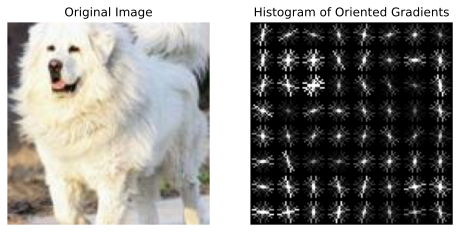

In [53]:
from skimage.feature import hog
from skimage import exposure

# Load an image
image = io.imread('/content/drive/MyDrive/Dog_Images/Tibetan_mastiff.jpeg')

# Compute HOG features
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Display the original image and HOG image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Original Image')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

Dimensionality reduction (using Principal Component Analysis, PCA)

In [54]:
def file_extraction(filename,lisp):
    folder_path = '/content/drive/MyDrive/Images/'+ filename
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            lisp.append(file_path)

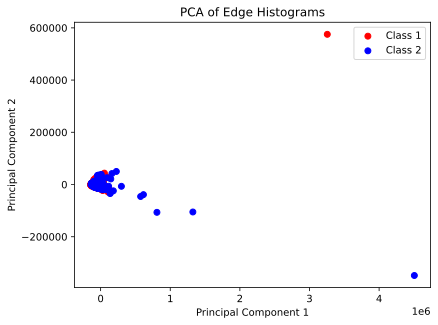

In [55]:
import numpy as np
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
class1_histograms =[]
class2_histograms =[]
# Load images from two classes
file_extraction('n02093859-Kerry_blue_terrier',class1_histograms)
file_extraction('n02108551-Tibetan_mastiff',class2_histograms)

# Convert images to edge histograms
def convert_to_edge_histograms(images):
    histograms = []
    for image_path in images:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        edges = cv2.Canny(image, 100, 200)
        hist, _ = np.histogram(edges, bins=36, range=(0, 255))
        histograms.append(hist)
    return np.array(histograms)

# Combine histograms from both classes
class1_histograms = convert_to_edge_histograms(class1_histograms)
class2_histograms = convert_to_edge_histograms(class2_histograms)
all_histograms = np.vstack((class1_histograms, class2_histograms))

# Perform PCA
pca = PCA(n_components=2)
pca.fit(all_histograms)
transformed_data = pca.transform(all_histograms)

# Plot 2D points with different colors for each class
plt.scatter(transformed_data[:len(class1_histograms), 0], transformed_data[:len(class1_histograms), 1], c='r', label='Class 1')
plt.scatter(transformed_data[len(class1_histograms):, 0], transformed_data[len(class1_histograms):, 1], c='b', label='Class 2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Edge Histograms')
plt.legend()
plt.show()